In [1]:

import pandas as pd
from lightgbm import LGBMRegressor
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from verstack import LGBMTuner, NaNImputer



/home/mak/Desktop/Project-X/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df_train = pd.read_csv('datasets/train.csv')
df_train.head()

,date_mutation,numero_disposition,valeur_fonciere,adresse_numero,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,nombre_lots,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,2019-07-01,1,244200.0,73.0,RUE COMMANDANT COUSTEAU,0958,1000.0,1053,Bourg-en-Bresse,1,0,Maison,150.0,5.0,695.0,5.264531,46.194443
1,2019-07-04,1,195000.0,852.0,CHE DE LA CROIX ROSIER,0170,1250.0,1184,Hautecourt-Romanèche,1,0,Maison,94.0,4.0,888.0,5.415689,46.159272
2,2019-07-04,1,195000.0,852.0,CHE DE LA CROIX ROSIER,0170,1250.0,1184,Hautecourt-Romanèche,1,0,Maison,94.0,4.0,500.0,5.415689,46.159272
3,2019-07-04,1,110030.0,5041.0,LA VILLE,B097,1250.0,1177,Grand-Corent,1,0,Maison,90.0,3.0,522.0,5.431065,46.199271
4,2019-07-03,1,160450.0,5515.0,CHARBONNET,B039,1270.0,1108,Coligny,1,0,Maison,110.0,5.0,2483.0,5.352696,46.384469


In [3]:

df_train.shape

(11511669, 17)

In [4]:
df_train = df_train[['longitude', 'latitude','type_local', 'nombre_pieces_principales', 'surface_reelle_bati', 'surface_terrain','valeur_fonciere']]

In [5]:
df_train.isna().sum()

longitude                    0
latitude                     0
type_local                   0
nombre_pieces_principales    0
surface_reelle_bati          0
surface_terrain              0
valeur_fonciere              0
dtype: int64

In [6]:
def surfaces(x):
    if x['type_local'] in ['Dépendance', 'Appartement']:
        return x['surface_reelle_bati']
    else:
        return x['surface_terrain'] 



In [7]:

df_train['surface'] = df_train.apply(surfaces, axis=1)

df_train.head()

,longitude,latitude,type_local,nombre_pieces_principales,surface_reelle_bati,surface_terrain,valeur_fonciere,surface
0,5.264531,46.194443,Maison,5.0,150.0,695.0,244200.0,695.0
1,5.415689,46.159272,Maison,4.0,94.0,888.0,195000.0,888.0
2,5.415689,46.159272,Maison,4.0,94.0,500.0,195000.0,500.0
3,5.431065,46.199271,Maison,3.0,90.0,522.0,110030.0,522.0
4,5.352696,46.384469,Maison,5.0,110.0,2483.0,160450.0,2483.0


In [8]:
df_train.head(10)

,longitude,latitude,type_local,nombre_pieces_principales,surface_reelle_bati,surface_terrain,valeur_fonciere,surface
0,5.264531,46.194443,Maison,5.0,150.00000,695.0,244200.0,695.00000
1,5.415689,46.159272,Maison,4.0,94.00000,888.0,195000.0,888.00000
2,5.415689,46.159272,Maison,4.0,94.00000,500.0,195000.0,500.00000
3,5.431065,46.199271,Maison,3.0,90.00000,522.0,110030.0,522.00000
4,5.352696,46.384469,Maison,5.0,110.00000,2483.0,160450.0,2483.00000
5,5.352696,46.384469,Maison,5.0,110.00000,557.0,160450.0,557.00000
6,5.253111,46.230982,Maison,4.0,108.00000,1159.0,211500.0,1159.00000
7,5.251446,46.212249,Maison,5.0,97.00000,314.0,180000.0,314.00000
8,5.242416,46.190963,Dépendance,0.0,70.98217,1206.0,216600.0,70.98217
9,5.242416,46.190963,Appartement,1.0,25.00000,1206.0,216600.0,25.00000


In [9]:
df_train.drop(columns = ['surface_reelle_bati', 'surface_terrain'], inplace = True)
df_train.head()

,longitude,latitude,type_local,nombre_pieces_principales,valeur_fonciere,surface
0,5.264531,46.194443,Maison,5.0,244200.0,695.0
1,5.415689,46.159272,Maison,4.0,195000.0,888.0
2,5.415689,46.159272,Maison,4.0,195000.0,500.0
3,5.431065,46.199271,Maison,3.0,110030.0,522.0
4,5.352696,46.384469,Maison,5.0,160450.0,2483.0


In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_train['type_local'] = le.fit_transform(df_train['type_local'])
df_train.head()

,longitude,latitude,type_local,nombre_pieces_principales,valeur_fonciere,surface
0,5.264531,46.194443,3,5.0,244200.0,695.0
1,5.415689,46.159272,3,4.0,195000.0,888.0
2,5.415689,46.159272,3,4.0,195000.0,500.0
3,5.431065,46.199271,3,3.0,110030.0,522.0
4,5.352696,46.384469,3,5.0,160450.0,2483.0


In [11]:
df_train.to_csv('df_train.csv', index=False)

## LGBM training

In [2]:
df_train = pd.read_csv('datasets/df_train_lgbm.csv')

In [3]:
x = df_train.drop(columns = ['valeur_fonciere'])
y = df_train['valeur_fonciere']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42)


In [4]:
# initialize with selected parameters
tuner = LGBMTuner(metric = 'mse',
                  trials = 250,
                  refit = True,
                  verbosity = 1,
                  visualization = False,
                  seed = 999,
                  device_type = 'gpu')


tuner.fit(x,y)


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 250 trials
     .. Evaluation metric: mse 
     .. Study direction: minimize mean_squared_error

     . Trial number: 0 finished
     .. Optimization score (lower-better): mean_squared_error: 181273650755471.84
     .. Evaluation score (lower-better): mse: 181273650755471.84
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): mean_squared_error: 129074768677713.86
     .. Evaluation score (lower-better): mse: 129074768677713.86
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): mean_squared_error: 143761556017334.5
     .. Evaluation score (lower-better): mse: 143761556017334.5
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): m

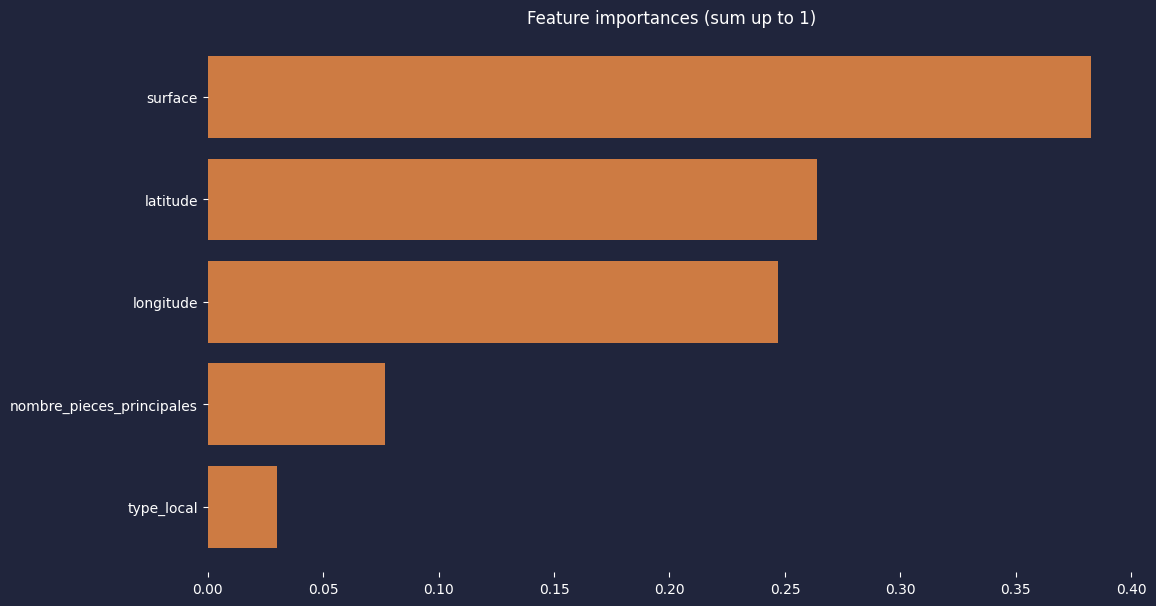

Feature Importance Plot is saved to /home/mak/Desktop/Project-X/FIM_DARK.png


<Figure size 640x480 with 0 Axes>

In [8]:
tuner.plot_importances(interactive = False)


In [7]:
tuner.best_params


{'learning_rate': 0.05,
 'num_leaves': 249,
 'feature_fraction': 0.9865551045258476,
 'bagging_fraction': 0.5233727476562136,
 'verbosity': -1,
 'random_state': 42,
 'device_type': 'gpu',
 'objective': 'regression',
 'metric': 'l2',
 'num_threads': 10,
 'min_sum_hessian_in_leaf': 7.589679108046483,
 'lambda_l1': 2.0980928472796925,
 'lambda_l2': 1.2769485508301184,
 'num_iterations': 2000}

{'learning_rate': 0.05,
 'num_leaves': 142,
 'feature_fraction': 0.9017140200398439,
 'bagging_fraction': 0.9,
 'verbosity': -1,
 'random_state': 42,
 'device_type': 'gpu',
 'objective': 'regression',
 'metric': 'l1',
 'num_threads': 10,
 'num_iterations': 2000}

In [5]:
import pickle as pkl

with open('lgbm_model_250_mse.pkl', 'wb') as f:
    pkl.dump(tuner, f)


In [6]:
with open('bestparams.txt', 'a') as f:
    f.write(str(tuner.best_params))
